In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from google.cloud import storage
import pandas as pd
from io import BytesIO
import numpy as np

In [2]:
# Step 1: Load stock price data
companies = ['CHKP', 'LUMI.TA', 'MBLY', 'NICE', 'POLI.TA']
stock_data = {}
# Create a GCS client
client = storage.Client()

In [3]:
# Function to read CSV from GCS
def read_csv_from_gcs(bucket_name, file_path):
    bucket = client.get_bucket(bucket_name)
    blob = storage.Blob(file_path, bucket)
    content = blob.download_as_bytes()
    return pd.read_csv(BytesIO(content))
for company in companies:
    file_path = f'{company}.csv'
    stock_data[company] = read_csv_from_gcs('datasets_project_group_20', file_path)

    # Display the first 5 rows of the DataFrame for each company
    print(f"First 5 rows of {company}:\n{stock_data[company].head()}\n")

First 5 rows of CHKP:
         Date        Open        High         Low       Close   Adj Close  \
0  2023-10-09  133.169998  135.750000  131.970001  134.970001  134.970001   
1  2023-10-10  135.210007  136.110001  134.869995  135.449997  135.449997   
2  2023-10-11  136.000000  136.220001  134.360001  134.369995  134.369995   
3  2023-10-12  134.089996  135.119995  132.619995  135.020004  135.020004   
4  2023-10-13  134.929993  135.380005  133.639999  134.309998  134.309998   

    Volume  
0  1288800  
1   792600  
2  1542000  
3   947200  
4  1135200  

First 5 rows of LUMI.TA:
         Date    Open    High     Low   Close  Adj Close   Volume
0  2023-10-08  2950.0  2979.0  2850.0  2875.0     2875.0  5031078
1  2023-10-09  2860.0  2940.0  2856.0  2867.0     2867.0  8207730
2  2023-10-10  2863.0  2917.0  2856.0  2877.0     2877.0  6325530
3  2023-10-11  2878.0  2895.0  2768.0  2768.0     2768.0  9394099
4  2023-10-12  2780.0  2805.0  2685.0  2710.0     2710.0  8251769

First 5 rows o

In [4]:
# Step 2: Load sentiment analysis data
file_path = 'reddit_data.csv'
reddit_data = read_csv_from_gcs('datasets_project_group_20', file_path)
# Display the first 5 rows of the DataFrame
print(f"First 5 rows of reddit_data:\n{reddit_data.head()}")
from textblob import TextBlob

# Assuming 'self_text' is the column containing comments
def analyze_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        # Assign sentiment labels (0 for neutral, 1 for positive, -1 for negative)
        return 0 if analysis.sentiment.polarity == 0 else (1 if analysis.sentiment.polarity > 0 else -1)
    else:
        return 0  # Assuming NaN values are neutral

First 5 rows of reddit_data:
  comment_id  score                                          self_text  \
0    k8klv28      1                                           Classic.   
1    k8klqxr      1  This is what i saying exactly\nOpen your huge ...   
2    k8kln5l      1  7/10 is the 3rd worst terrorist attack in HIST...   
3    k8klm8v      1                    Usually Muslims killing Muslims   
4    k8klg6w      1  They both want to destroy each other with no r...   

         subreddit               created_time  
0        worldnews  2023-11-09 23:23:46+00:00  
1  IsraelPalestine  2023-11-09 23:22:59+00:00  
2  IsraelPalestine  2023-11-09 23:22:16+00:00  
3  IsraelPalestine  2023-11-09 23:22:06+00:00  
4        worldnews  2023-11-09 23:20:57+00:00  


In [5]:
# Apply sentiment analysis to the Reddit data
reddit_data['sentiment'] = reddit_data['self_text'].apply(analyze_sentiment)

# You can drop the 'self_text' column if it's no longer needed
reddit_data = reddit_data.drop(columns=['self_text'])

# Display the first 5 rows of the DataFrame
print(f"First 5 rows of reddit_data:\n{reddit_data.head()}")
# Convert 'created_time' to datetime and extract date
reddit_data['created_time'] = pd.to_datetime(reddit_data['created_time'])
reddit_data['Date'] = reddit_data['created_time'].dt.strftime('%Y-%m-%d')

First 5 rows of reddit_data:
  comment_id  score        subreddit               created_time  sentiment
0    k8klv28      1        worldnews  2023-11-09 23:23:46+00:00          1
1    k8klqxr      1  IsraelPalestine  2023-11-09 23:22:59+00:00          1
2    k8kln5l      1  IsraelPalestine  2023-11-09 23:22:16+00:00         -1
3    k8klm8v      1  IsraelPalestine  2023-11-09 23:22:06+00:00         -1
4    k8klg6w      1        worldnews  2023-11-09 23:20:57+00:00         -1


In [7]:
# Group by date and sentiment, then calculate the percentage for each sentiment
sentiment_percentage = reddit_data.groupby(['Date', 'sentiment']).size().unstack(fill_value=0)
sentiment_percentage = sentiment_percentage.div(sentiment_percentage.sum(axis=1), axis=0)

# Rename columns for clarity
sentiment_percentage.columns = ['negative_sentiment', 'neutral_sentiment', 'positive_sentiment']

# Reset index to make 'date' a regular column
sentiment_percentage = sentiment_percentage.reset_index()

# Display the result
print(sentiment_percentage)
# Convert 'Date' to datetime in sentiment_percentage
sentiment_percentage['Date'] = pd.to_datetime(sentiment_percentage['Date'])


          Date  negative_sentiment  neutral_sentiment  positive_sentiment
0   2023-10-06            0.285714           0.571429            0.142857
1   2023-10-07            0.287598           0.311861            0.400541
2   2023-10-08            0.286110           0.303296            0.410594
3   2023-10-09            0.278047           0.300830            0.421123
4   2023-10-10            0.274905           0.304162            0.420933
5   2023-10-11            0.269614           0.289690            0.440697
6   2023-10-12            0.271453           0.291429            0.437117
7   2023-10-13            0.277290           0.289894            0.432816
8   2023-10-14            0.273001           0.298667            0.428333
9   2023-10-15            0.258337           0.296246            0.445417
10  2023-10-16            0.269075           0.284805            0.446120
11  2023-10-17            0.268138           0.296067            0.435795
12  2023-10-18            0.274912    

In [8]:
# Create an empty list to store merged dataframes for all companies
all_merged_data = []

In [9]:
# Merge each company's stock data with sentiment_percentage
for company in companies:
    # Convert 'Date' to datetime in each company's stock data
    stock_data[company]['Date'] = pd.to_datetime(stock_data[company]['Date'])
    
    # Merge with sentiment_percentage on 'Date'
    merged_data = pd.merge(stock_data[company], sentiment_percentage, how='left', left_on='Date', right_on='Date')
    
    # Fill missing values with zeros (if there are dates without sentiment data)
    merged_data = merged_data.fillna(0)
    
    # Add a new column 'Company' with the company name
    merged_data['Company'] = company
    
    # Append the merged dataframe to the list
    all_merged_data.append(merged_data)

In [10]:
# Concatenate all dataframes in the list to create a single dataframe
final_merged_data = pd.concat(all_merged_data, ignore_index=True)

# Display the result for all companies
print("Merged data for all companies:\n", final_merged_data.head())

Merged data for all companies:
         Date        Open        High         Low       Close   Adj Close  \
0 2023-10-09  133.169998  135.750000  131.970001  134.970001  134.970001   
1 2023-10-10  135.210007  136.110001  134.869995  135.449997  135.449997   
2 2023-10-11  136.000000  136.220001  134.360001  134.369995  134.369995   
3 2023-10-12  134.089996  135.119995  132.619995  135.020004  135.020004   
4 2023-10-13  134.929993  135.380005  133.639999  134.309998  134.309998   

    Volume  negative_sentiment  neutral_sentiment  positive_sentiment Company  
0  1288800            0.278047           0.300830            0.421123    CHKP  
1   792600            0.274905           0.304162            0.420933    CHKP  
2  1542000            0.269614           0.289690            0.440697    CHKP  
3   947200            0.271453           0.291429            0.437117    CHKP  
4  1135200            0.277290           0.289894            0.432816    CHKP  


In [12]:
# Define a function to train and predict using the specified model
def predict_stock_prices(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [13]:
# Dictionary to store predicted dataframes for each company
predicted_dfs = {}

# Loop through each company
for company in companies:
    # Select features and target variable for the current company
    company_data = final_merged_data[final_merged_data['Company'] == company]
    features = company_data[['negative_sentiment', 'neutral_sentiment', 'positive_sentiment']]
    target = company_data['Close']  # Assuming 'Close' is the target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Random Forest Regression
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_predictions = predict_stock_prices(rf_model, X_train, y_train, X_test)

    # Linear Regression
    lr_model = LinearRegression()
    lr_predictions = predict_stock_prices(lr_model, X_train, y_train, X_test)

    # Support Vector Regression
    svr_model = SVR(kernel='linear')
    svr_predictions = predict_stock_prices(svr_model, X_train, y_train, X_test)

    # Create a dataframe with actual and predicted values
    predicted_df = pd.DataFrame({
        'Date': company_data.loc[X_test.index, 'Date'].values,
        'Actual': y_test.values,
        f'Predicted_RF_{company}': rf_predictions,
        f'Predicted_LR_{company}': lr_predictions,
        f'Predicted_SVR_{company}': svr_predictions
    })

    # Sort the dataframe by 'Date' in ascending order
    predicted_df = predicted_df.sort_values('Date')

    # Add the dataframe to the dictionary
    predicted_dfs[company] = predicted_df

# Print or use the dataframes as needed
for company, predicted_df in predicted_dfs.items():
    print(f"\nPredicted {company}:")
    print(predicted_df)




Predicted CHKP:
        Date      Actual  Predicted_RF_CHKP  Predicted_LR_CHKP  \
2 2023-10-09  134.970001         134.489398              134.0   
0 2023-10-19  135.500000         135.282104              133.0   
4 2023-10-24  136.279999         134.927897              135.0   
1 2023-10-31  134.250000         131.149597              134.0   
3 2023-11-02  136.580002         134.209500              133.0   

   Predicted_SVR_CHKP  
2          135.369987  
0          135.370185  
4          135.371266  
1          135.370770  
3          135.370274  

Predicted LUMI.TA:
        Date  Actual  Predicted_RF_LUMI.TA  Predicted_LR_LUMI.TA  \
2 2023-10-08  2875.0               2850.82                3020.0   
0 2023-10-18  2661.0               2791.82                2788.0   
4 2023-10-23  2451.0               2660.49                2636.0   
1 2023-10-30  2672.0               2722.53                2708.0   
3 2023-11-08  2794.0               2575.66                2524.0   

   Predicted_

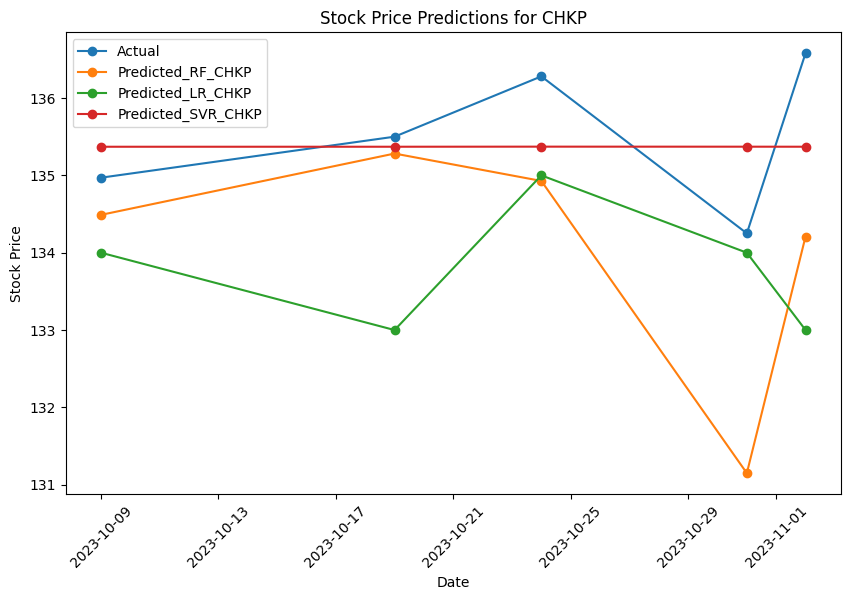

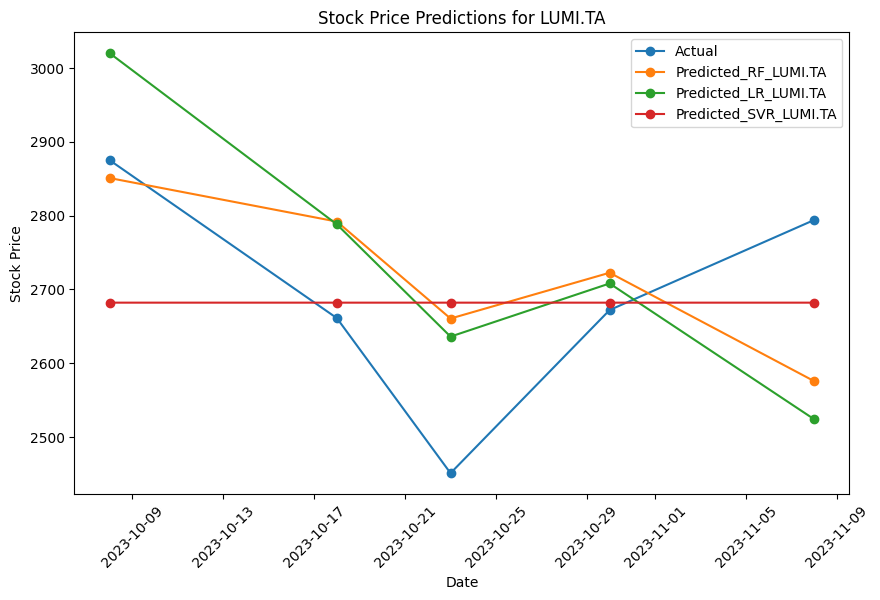

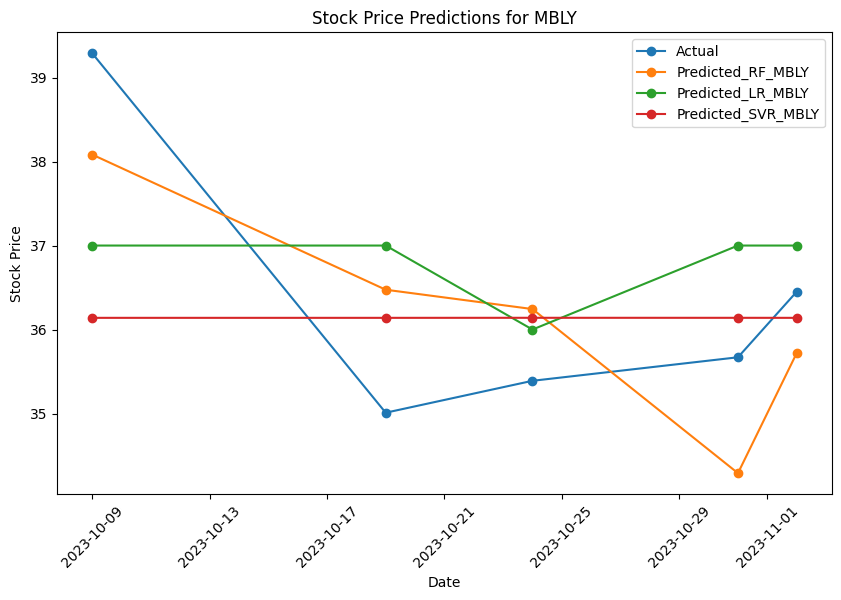

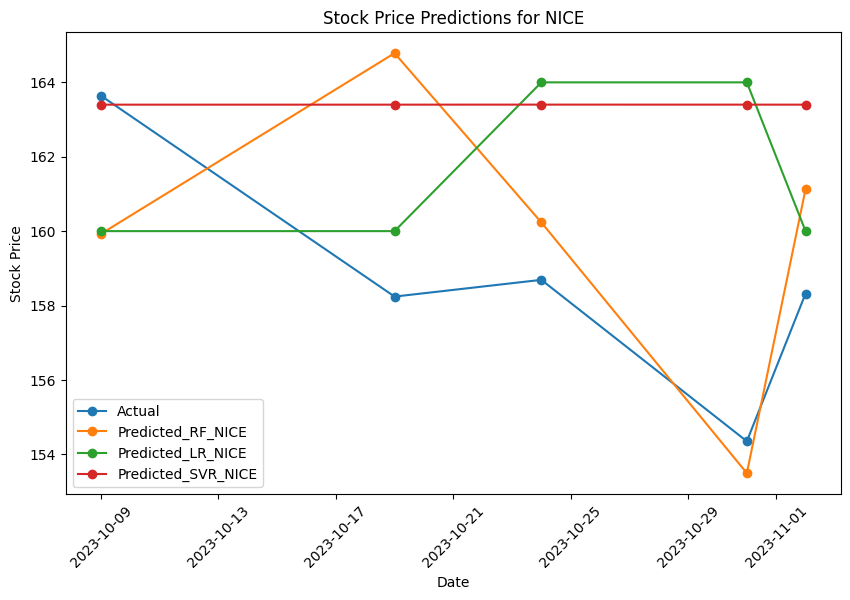

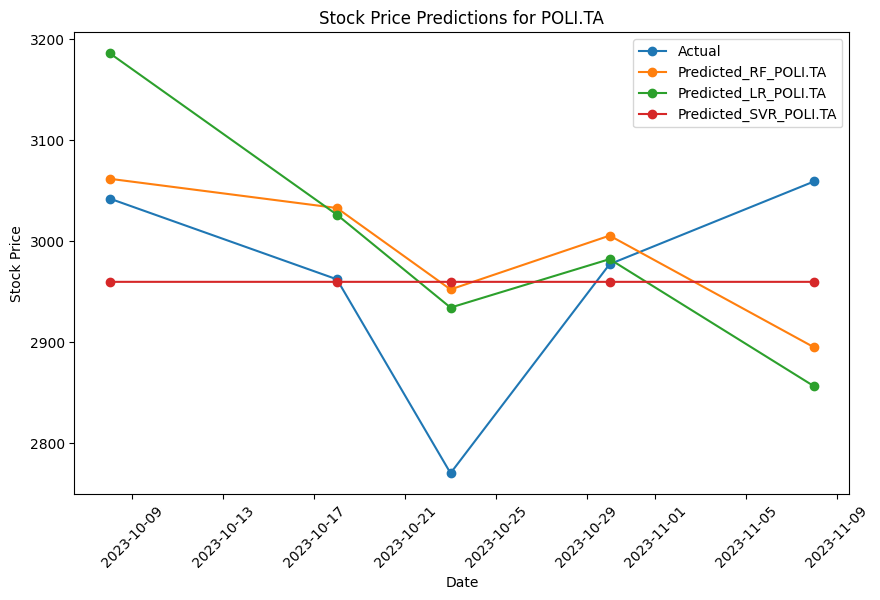

In [14]:
# Function to plot the data for a specific company
def plot_predictions(df, company_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Actual'], label='Actual', marker='o')
    plt.plot(df['Date'], df[f'Predicted_RF_{company_name}'], label=f'Predicted_RF_{company_name}', marker='o')
    plt.plot(df['Date'], df[f'Predicted_LR_{company_name}'], label=f'Predicted_LR_{company_name}', marker='o')
    plt.plot(df['Date'], df[f'Predicted_SVR_{company_name}'], label=f'Predicted_SVR_{company_name}', marker='o')
    
    plt.title(f"Stock Price Predictions for {company_name}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Plot for CHKP
plot_predictions(predicted_dfs['CHKP'], 'CHKP')

# Plot for LUMI.TA
plot_predictions(predicted_dfs['LUMI.TA'], 'LUMI.TA')

# Plot for MBLY
plot_predictions(predicted_dfs['MBLY'], 'MBLY')

# Plot for NICE
plot_predictions(predicted_dfs['NICE'], 'NICE')

# Plot for POLI.TA
plot_predictions(predicted_dfs['POLI.TA'], 'POLI.TA')

In [15]:
# Loop through each company
for company in companies:
    # Select features and target variable for the current company
    company_data = final_merged_data[final_merged_data['Company'] == company]
    features = company_data[['negative_sentiment', 'neutral_sentiment', 'positive_sentiment']]
    target = company_data['Close']  # Assuming 'Close' is the target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Random Forest Regression
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_predictions = predict_stock_prices(rf_model, X_train, y_train, X_test)
    rf_mse = mean_squared_error(y_test, rf_predictions)

    # Linear Regression
    lr_model = LinearRegression()
    lr_predictions = predict_stock_prices(lr_model, X_train, y_train, X_test)
    lr_mse = mean_squared_error(y_test, lr_predictions)

    # Support Vector Regression
    svr_model = SVR(kernel='linear')
    svr_predictions = predict_stock_prices(svr_model, X_train, y_train, X_test)
    svr_mse = mean_squared_error(y_test, svr_predictions)

    # Dynamically divide MSE values by 10 until they become less than 1
    scaling_factor = 1
    while max(rf_mse, lr_mse, svr_mse) >= 1:
        rf_mse /= 10
        lr_mse /= 10
        svr_mse /= 10
        scaling_factor *= 10

    # Print scaled MSE values for each model
    print(f'Mean Squared Error for {company}:')
    print(f'Random Forest: {rf_mse}')
    print(f'Linear Regression: {lr_mse}')
    print(f'SVR: {svr_mse}')
    print('---------------------------')

    # Create a dataframe with actual and predicted values
    predicted_df = pd.DataFrame({
        'Date': company_data.loc[X_test.index, 'Date'].values,
        'Actual': y_test.values,
        f'Predicted_RF_{company}': rf_predictions,
        f'Predicted_LR_{company}': lr_predictions,
        f'Predicted_SVR_{company}': svr_predictions
    })

    # Sort the dataframe by 'Date' in ascending order
    predicted_df = predicted_df.sort_values('Date')

    # Add the dataframe to the dictionary
    predicted_dfs[company] = predicted_df

Mean Squared Error for CHKP:
Random Forest: 0.34676835653370286
Linear Regression: 0.4341642740001211
SVR: 0.07444408307270148
---------------------------
Mean Squared Error for LUMI.TA:
Random Forest: 0.22362048280000008
Linear Regression: 0.29114999999999996
SVR: 0.20738640374931686
---------------------------
Mean Squared Error for MBLY:
Random Forest: 0.13532197821207953
Linear Regression: 0.23295435960021935
SVR: 0.24162486491493515
---------------------------
Mean Squared Error for NICE:
Random Forest: 0.13522287293201535
Linear Regression: 0.28097602912022973
SVR: 0.313230569058504
---------------------------
Mean Squared Error for POLI.TA:
Random Forest: 0.13262512859999998
Linear Regression: 0.18592400000000003
SVR: 0.10585732565662664
---------------------------
